In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
from shapely.geometry import Point,MultiPoint
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
#import rasterio 
from scipy import stats
from IPython.display import Image
#from pygeotools.lib import  iolib,geolib,warplib,malib
#import skgstat as skg
from scipy.optimize import curve_fit
from scipy.optimize import leastsq, fmin_slsqp,least_squares
from scipy.optimize import fmin as simplex
import string
from multiprocessing import cpu_count, Pool
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
def min_dist_helper(shp_geom):
    """
    returns a coloumn with distance from nearest neighbour for each point
    """
    #geom = row.geometry
    shp = shp_geom[0]
    geom = shp_geom[1]
    dist = shp['geometry'].distance(geom).values
    min_dist = np.min(dist[np.nonzero(dist)])
    return min_dist
#something to consider in the future

In [4]:
def min_dist_calc(shp):
    """
    Calclates distance to nearest neighbour for points contained in a shapefile
    """
    with Pool(100) as p:
        geom_array = shp.geometry.values
        gdf_list_input = [shp]*len(shp)
        gdf_list_pass = list(zip(gdf_list_input,geom_array))
        out = p.map(min_dist_helper, [gdf for gdf in gdf_list_pass])
        # we should be fine with order, multiproc maintians order by default
    return out

In [118]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical(X,tpl):
    #tpl[0] = nugget
    #tpl[1] = sill
    #tpl[2] = hrange
    i=0
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y
error_func = lambda tpl,x,y: (spherical(x,tpl)-y)**2

In [6]:
def exponential(X,tpl):
    X = np.array(X)
    Y = tpl[0]+ tpl[1]*(1-np.exp(-(X/tpl[2])))
    idx = X == 0
    Y[idx] = 0
    return Y
error_func_exp = lambda tpl,x,y: exponential(x,tpl)-y

In [7]:
def gauss(X,tpl):
    X = np.array(X)
    Y = tpl[0]+ tpl[1]*(1-np.exp(-(X/tpl[2])**2))
    idx = X == 0
    Y[idx] = 0
    return Y
error_func_gauss = lambda tpl,x,y: gauss(x,tpl)-y

In [8]:

def vario_plt_ref(lag,gamma,lag_m,gamma_m,hrange,rgi_title,nugget,ax,sill):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    ax.plot(lag_m,gamma_m,'g^',label='Modelled Semivariogram',markersize=3)
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    hrange_round = np.round(hrange,decimals=2)
    nugget_round = np.round(nugget,decimals=2)
    title_str = '{} \n range of influence = {}m \n nugget = {} \n sill = {}'.format(rgi_title,hrange_round,nugget_round,np.round(sill,2))
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig
    

In [9]:

def simple_vario_plt(lag,gamma,rgi_title,ax):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    #ax.plot(lag_m,gamma_m,'g^',label='Modelled Variogram')
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    #ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    #hrange_round = np.round(hrange,decimals=2)
    #nugget_round = np.round(nugget,decimals=2)
    title_str = 'Model fit failed\n {}'.format(rgi_title)
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig
    

In [144]:
def variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,0,180,0)
    tpl_init = (0.0,0.0,40000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_sph= least_squares(error_func,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        #tpl_final_sph= simplex(error_func,tpl_init[:],args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = spherical(lag_experi,tpl_final_sph.x)
        hrange_mod = tpl_final_sph.x[-1]
        nugget = tpl_final_sph.x[0]
        sill = tpl_final_sph.x[1]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod = [0]
        nugget = [0]
        sill = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,hrange_mod,nugget,sill

In [11]:
def exp_variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,0,90,0)
    tpl_init = (0,0.2,10000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_exp= least_squares(error_func_exp,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = exponential(lag_experi,tpl_final_exp.x)
        hrange_mod = tpl_final_exp.x[-1]
        nugget = tpl_final_exp.x[0]
        sill = tpl_final_exp.x[1]
        #actual range is lag distance at which 95% of sill is achieved
        mod_sill = 0.95*sill
        idx = np.argmax(gamma_mod>=mod_sill)
        mod_range = lag_mod[idx]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod = [0]
        nugget = [0]
        sill = [0]
        mod_sill = [0]
        idx = [0]
        mod_range = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,mod_range,nugget,sill

In [12]:
def gauss_variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,0,90,1)
    tpl_init = (0,0.2,100000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_gauss= least_squares(error_func_gauss,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = gauss(lag_experi,tpl_final_gauss.x)
        hrange_mod = tpl_final_gauss.x[-1]
        nugget = tpl_final_gauss.x[0]
        sill = tpl_final_gauss.x[1]
        #actual range is lag distance at which 95% of sill is achieved
        mod_sill = 0.95*sill
        idx = np.argmax(gamma_mod>=mod_sill)
        mod_range = lag_mod[idx]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod =[0]
        nugget = [0]
        sill = [0]
        mod_sill = [0]
        idx = [0]
        mod_range = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,mod_range,nugget,sill

In [13]:
figdir = '/mnt/Shared_OS_Storage/scp_temp/variogram_figs'
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Note on how optimum lag distance can be computed 
- Analysis shows that result is dependent on the choice of lag distance
- Based on the reccommendations, we chose the lag distance as the mean/median of the nearest neighbour distances
- This is attempted on glacier centroids with Python multiprocessing utility (which nakes it possible to do it for ~95 k points)

In [14]:
nmad_df = pd.read_csv('./mb_20190213/hma_mb_20190214_1015_nmad.csv')
std_df = pd.read_csv('./mb_20190213/hma_mb_20190213_1924_std.csv')
std_mean_df = pd.read_csv('hma_mb_20190215_0815_std+mean.csv')

In [15]:
nmad_df.head(2)

,RGIId,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,...,t1,t2,dt,valid_area_perc,H_m,debris_m,perc_debris,perc_pond,perc_clean,vm_ma
0,14.06629,-747305.504,11409.822,7821.871,7707.358,7925.199,58.563,71.159,-1.141,1.319,...,2000.412,2018.412,18.0,97.820,NaN,NaN,NaN,NaN,NaN,NaN
1,15.05152,-145758.234,-820691.042,7818.454,7435.899,8144.735,36.931,25.958,0.588,0.549,...,2000.412,2018.412,18.0,99.985,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
nmad_df.keys()

Index(['RGIId', 'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect',
       'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2',
       'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc',
       'H_m', 'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma'],
      dtype='object')

In [19]:
nmad_df['geometry'] = list(zip(nmad_df.x,nmad_df.y))
nmad_df['geometry'] = nmad_df['geometry'].apply(Point)
dummy_crs = gpd.read_file('/mnt/Backups/reference_data/data/rgi60/regions/rgi60_merge_HMA_aea.shp').crs
nmad_gdf = gpd.GeoDataFrame(nmad_df,geometry='geometry',crs=dummy_crs)

In [18]:
nmad_gdf.head(4)

,RGIId,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,...,t2,dt,valid_area_perc,H_m,debris_m,perc_debris,perc_pond,perc_clean,vm_ma,geometry
0,14.06629,-747305.504,11409.822,7821.871,7707.358,7925.199,58.563,71.159,-1.141,1.319,...,2018.412,18.0,97.820,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-747305.5040000001 11409.822)
1,15.05152,-145758.234,-820691.042,7818.454,7435.899,8144.735,36.931,25.958,0.588,0.549,...,2018.412,18.0,99.985,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-145758.234 -820691.042)
2,15.02790,305153.261,-927260.154,7688.865,7324.962,7822.692,17.832,65.674,0.002,0.175,...,2018.412,18.0,99.931,NaN,NaN,NaN,NaN,NaN,NaN,POINT (305153.261 -927260.1540000001)
3,15.02793,307937.214,-927265.323,7687.291,7387.414,8068.165,31.805,321.875,0.105,0.422,...,2018.412,18.0,98.797,NaN,NaN,NaN,NaN,NaN,NaN,POINT (307937.214 -927265.323)


# Note (Time hogger) 
- THE neigherest neighbour distance calculation takes some time to calculate. I am knowingly commenting it here and alloting the values I obtained from running this. Biggest time consuming block.

In [16]:
glac_area_df = std_mean_df
glac_area_df['area_km2'] = glac_area_df['area_m2']*1e-6

In [17]:
glac_area_df_big = glac_area_df[glac_area_df['area_km2']>=0.785]

In [20]:
glac_area_df_big['geometry'] = list(zip(glac_area_df_big.x,glac_area_df_big.y))
glac_area_df_big['geometry'] = glac_area_df_big['geometry'].apply(Point)
#dummy_crs = gpd.read_file('/mnt/Backups/reference_data/data/rgi60/regions/rgi60_merge_HMA_aea.shp').crs
glac_area_gdf_big = gpd.GeoDataFrame(glac_area_df_big,geometry='geometry',crs=dummy_crs)

/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
len(glac_area_gdf_big)

19663

In [24]:
glac_area_gdf_big[['area_m2']].describe()

,area_m2
count,1.966300e+04
mean,4.078062e+06
std,1.662505e+07
min,7.850502e+05
25%,1.081175e+06
50%,1.643142e+06
75%,3.149634e+06
max,1.077958e+09


In [98]:
glac_area_gdf_big.to_file('/mnt/Shared_OS_Storage/scp_temp/big_glaciers_gdf_arc.gpkg',driver='GPKG')

In [100]:
nmad_gdf.to_file('/mnt/Shared_OS_Storage/scp_temp/all_glaciers_gdf_arc.gpkg',driver='GPKG')

In [25]:
glac_area_gdf_big['min_dist'] = min_dist_calc(glac_area_gdf_big)

In [26]:
glac_area_gdf_big['min_dist'].mean()

2164.1169103464417

In [27]:
glac_area_gdf_big['min_dist'].median()

1778.9389483151429

In [28]:
glac_area_gdf_big['min_dist'].max()*1e-3

106.75947264469993

In [29]:
median_near_neig = glac_area_gdf_big['min_dist'].median()

In [30]:
mean_near_neig = glac_area_gdf_big['min_dist'].mean()

In [36]:
median_near_neig = 2647.1927287670505
mean_near_neig = 3358.4758775898345

# Note on lag distance and number of lag used
- we fix lag distance at median nearest neighbour distance, no of lags at 100, so total spatial distance modeled = 786.477 *100 = ~79 km

- this is an omnidirectional variogram search (0 to 90 degree search for pairs)


In [20]:
nmad_df.keys()

Index(['RGIId', 'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect',
       'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2',
       'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc',
       'H_m', 'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma',
       'geometry'],
      dtype='object')

In [63]:
len(glac_area_df_big)

19663

<IPython.core.display.Javascript object>


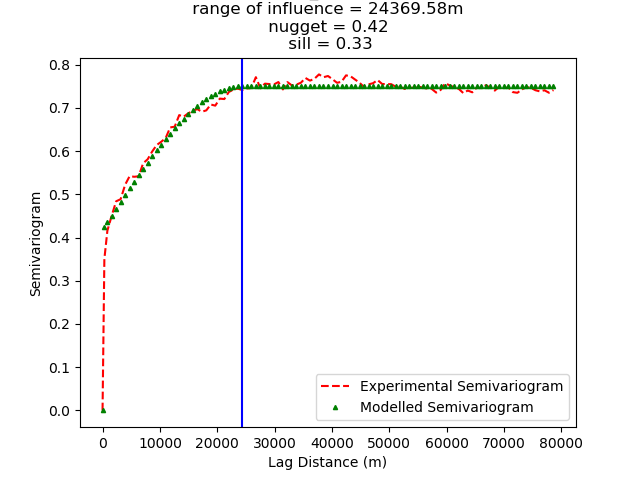

In [19]:
fig,axa = plt.subplots()
z = 'mb_mwea'
nlags = 100
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

In [112]:
median_near_neig*4

7115.755793260571

In [105]:
len(glac_area_df_big)

19663

In [72]:
(glac_area_gdf_big['mb_m3wea_sigma']).describe()

count    1.966300e+04
mean     7.190795e+05
std      2.184502e+06
min      3.522073e+04
25%      1.907210e+05
50%      3.244440e+05
75%      6.207647e+05
max      1.471423e+08
Name: mb_m3wea_sigma, dtype: float64

In [21]:
glac_area_df_big['test_sigma'] = glac_area_df_big['mb_m3wea_sigma']/200
glac_area_df_big['mb_Gta'] = glac_area_df_big['mb_m3wea']/1E9

/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
glac_area_df_big['mb_Gta_sigma'] = glac_area_df_big['mb_m3wea_sigma']/1E9
glac_area_df_big['mb_Mta_sigma'] = glac_area_df_big['mb_m3wea_sigma']/1E6
glac_area_df_big['mb_Kta_sigma'] = glac_area_df_big['mb_m3wea_sigma']/1E3
std_mean_df['mb_Mta_sigma'] = std_mean_df['mb_m3wea_sigma']/1E6
glac_area_df_big['mb_Mta'] = glac_area_df_big['mb_m3wea']/1E6

/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [139]:
std_mean_df['mb_Mta'] = std_mean_df['mb_m3wea']/1E6

<IPython.core.display.Javascript object>


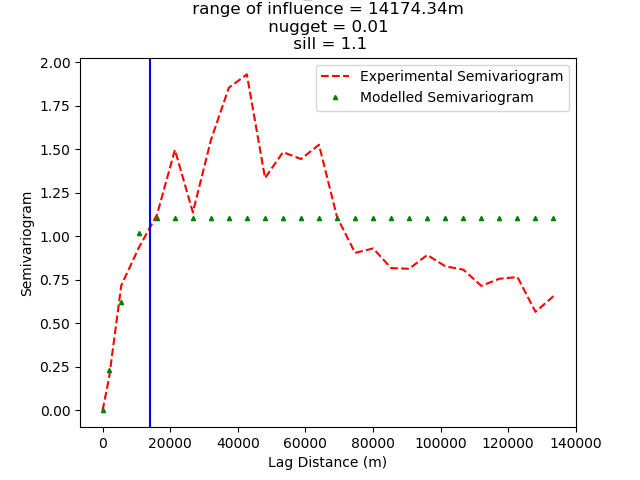

In [57]:
fig,axa = plt.subplots()
z = 'mb_m3wea'
nlags = 25
lag_dist = median_near_neig*3
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

<IPython.core.display.Javascript object>


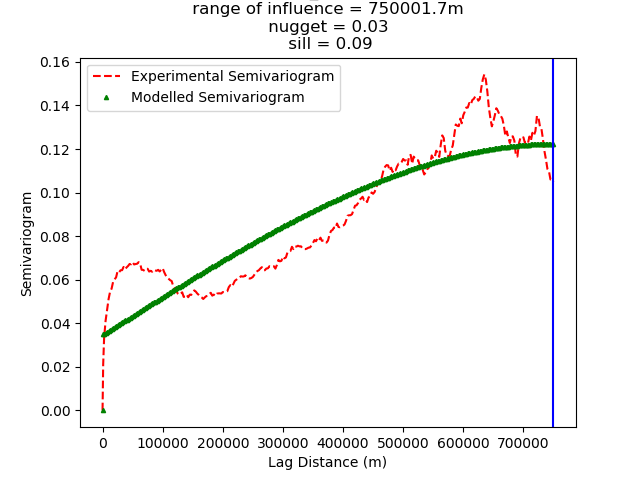

In [138]:
fig,axa = plt.subplots()
z = 'mb_mwea'
nlags = 300
lag_dist = 2500
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

<IPython.core.display.Javascript object>


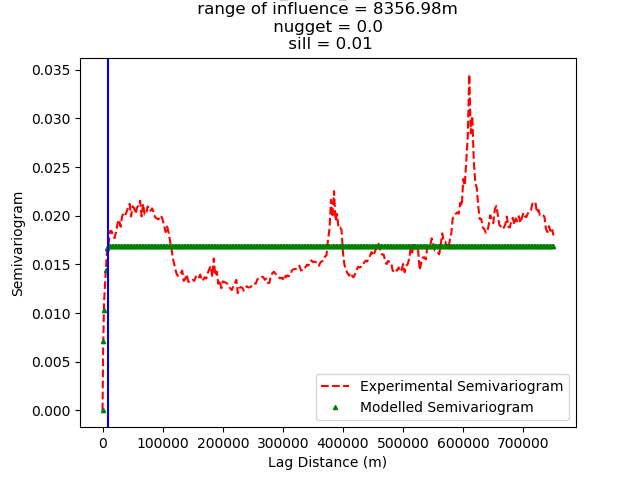

In [159]:
fig,axa = plt.subplots()
z = 'mb_mwea_sigma'
nlags = 300
lag_dist = 2500
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

In [131]:
(std_mean_df['mb_Mta_sigma'].std())**2

1.0633455628595299

In [123]:
2.18*2.18

4.752400000000001

In [34]:
(glac_area_df_big['mb_Mta_sigma'].std())**2

4.772048741563392

<IPython.core.display.Javascript object>


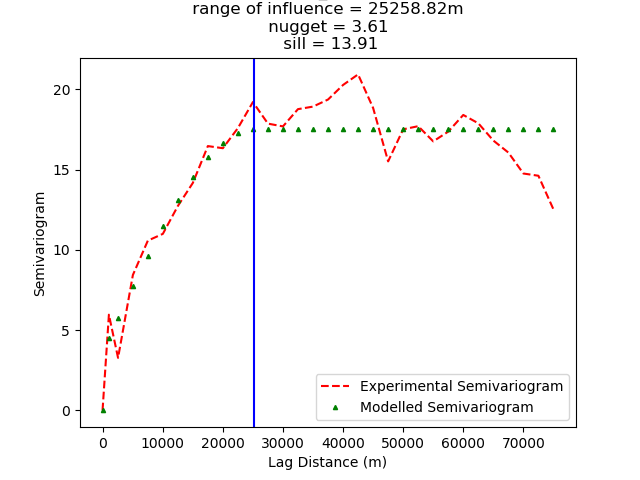

In [150]:
fig,axa = plt.subplots()
z = 'mb_Mta'
nlags = 30
lag_dist = 2500
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

<IPython.core.display.Javascript object>


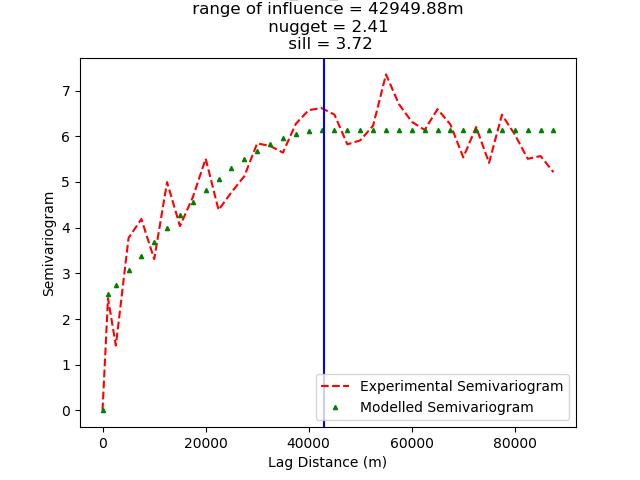

In [175]:
fig,axa = plt.subplots()
z = 'mb_Mta_sigma'
nlags = 35
lag_dist = 2500
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

In [ ]:
fig,axa = plt.subplots()
z = 'mb_Mta_sigma'
nlags = 80
lag_dist = 2500
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(glac_area_df_big,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

##### transform coordinates ?

<IPython.core.display.Javascript object>


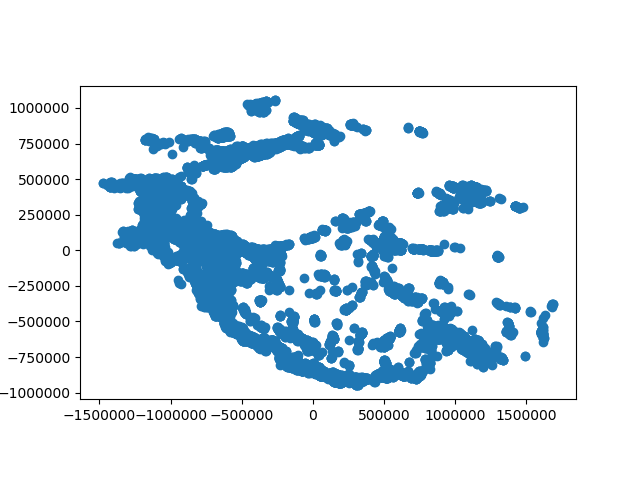

In [176]:
glac_area_gdf_big.plot()

In [23]:
xmin,ymin,xmax,ymax = glac_area_gdf_big.total_bounds

In [24]:
glac_area_df_big['x_trans'] = glac_area_df_big['x']-xmin
glac_area_df_big['y_trans'] = glac_area_df_big['y'] -ymin

/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


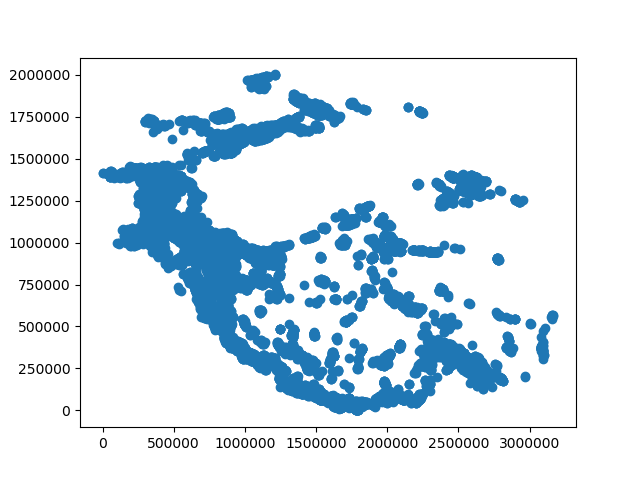

In [25]:
fig,ax = plt.subplots()
ax.scatter(glac_area_df_big['x_trans'],glac_area_df_big['y_trans'])

In [141]:
glac_area_df_big[z].std()**2

0.027271158895474386

In [152]:
nmad_df[z].std()**2

0.04588718889082878

<IPython.core.display.Javascript object>


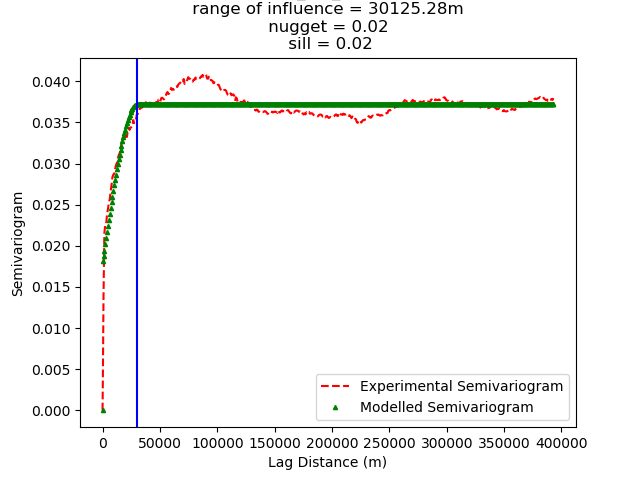

In [183]:
fig,axa = plt.subplots()
z = 'dhdt_ma_sigma'
nlags = 500
lag_dist = 786
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

<IPython.core.display.Javascript object>


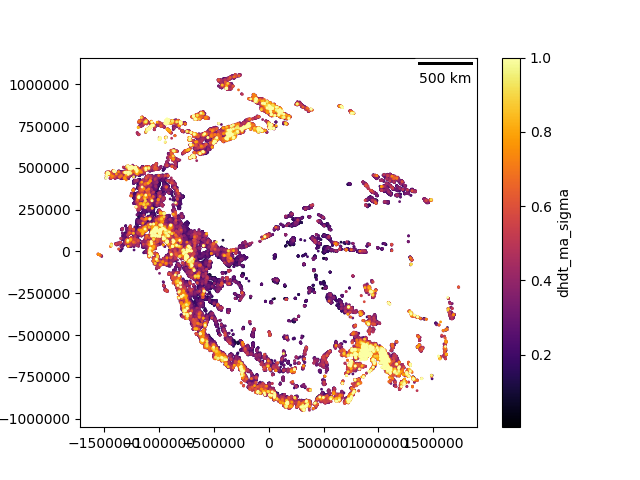

In [180]:
fig,ax = plt.subplots()
nmad_df_sort = nmad_df.sort_values(by='dhdt_ma_sigma',ascending=True)
im = ax.scatter(nmad_df_sort['x'],nmad_df_sort['y'],c=nmad_df_sort['dhdt_ma_sigma'],cmap='inferno',vmax=1,s=1)
plt.colorbar(im,label='dhdt_ma_sigma')
scalebar = ScaleBar(1.0)
ax.add_artist(scalebar)

In [157]:
std_mean_df[z].std()**2

0.1302240818845965

<IPython.core.display.Javascript object>


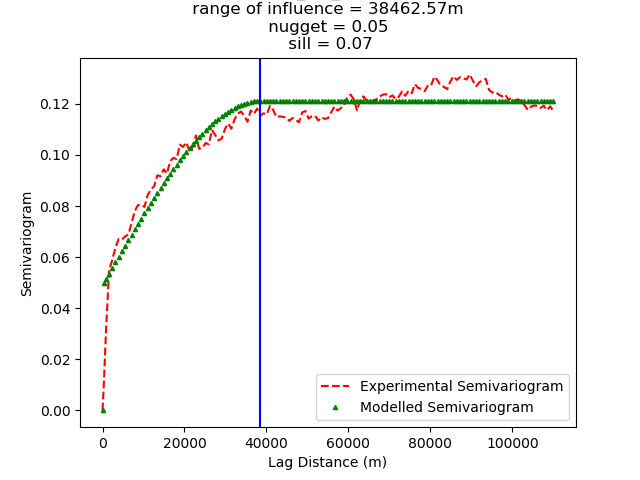

In [155]:
fig,axa = plt.subplots()
z = 'dhdt_ma_sigma'
nlags = 140
lag_dist = 786
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

In [170]:
std_mean_df_sort = std_mean_df.sort_values(by='dhdt_ma_sigma',ascending=True)

In [171]:
std_mean_df_sort.dhdt_ma_sigma.values

array([1.5000e-02, 1.7000e-02, 1.8000e-02, ..., 1.0463e+01, 1.4236e+01,
       1.5579e+01])

<IPython.core.display.Javascript object>


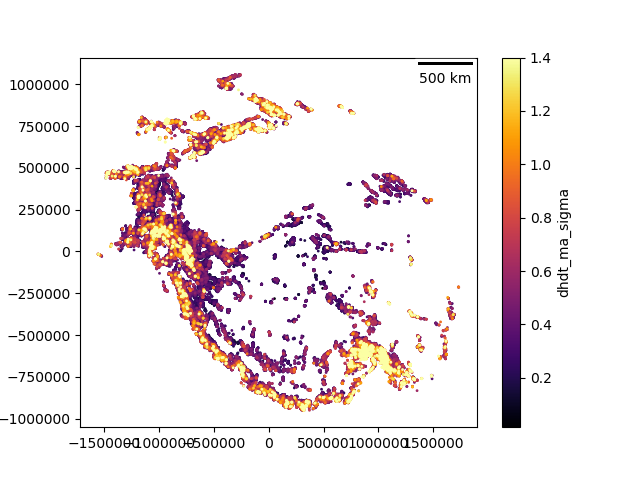

In [177]:
fig,ax = plt.subplots()
im = ax.scatter(std_mean_df_sort['x'],std_mean_df_sort['y'],c=std_mean_df_sort['dhdt_ma_sigma'],cmap='inferno',vmax=1.4,s=1)
plt.colorbar(im,label='dhdt_ma_sigma')
scalebar = ScaleBar(1.0)
ax.add_artist(scalebar)

In [128]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical_curve(X,nugget,sill,hrange):
    #tpl[0] = nugget
    #tpl[1] = sill
    #tpl[2] = hrange
    i=0
    tpl = [nugget,sill,hrange]
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y
error_func = lambda tpl,x,y: spherical(x,tpl)-y

In [60]:
np.max(lag_mb)

399999.236

In [67]:
np.max(gamma_mb)

7.12652

In [130]:
tpl_init = [0,7,100000]
#tpl_final_sph= fmin_slsqp(error_func,tpl_init,args=(lag_mb,gamma_mb))
tpl_final_sph_curve_fit,_ = curve_fit(spherical_curve,lag_mb,gamma_mb)

In [132]:
curve_fit(spherical_curve,lag_mb,gamma_mb)

/home/shashank/.conda/envs/bhushanPy3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([-67.54382521,  72.2399072 ,   1.        ]), array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

In [120]:
tpl_init = [0,7,100000]
#tpl_final_sph= fmin_slsqp(error_func,tpl_init,args=(lag_mb,gamma_mb))
tpl_final_sph= least_squares(error_func,tpl_init[:],bounds=((0,6,80000),(np.max(gamma_mb),np.max(gamma_mb),np.max(lag_mb))),args=(lag_mb,gamma_mb))

In [121]:
tpl_final_sph.x

array([1.93797585e-17, 6.00000004e+00, 8.00000000e+04])

In [122]:
tpl_final_sph

 active_mask: array([-1, -1, -1])
        cost: 1300.3979176208027
         fun: array([0.00000000e+00, 4.81667571e+00, 1.09263217e+00, 2.23616303e+00,
       1.87644401e+01, 8.62873822e+00, 5.80804938e+00, 1.14318828e+01,
       8.96926212e+00, 4.87194520e+00, 8.16524850e+00, 1.18951663e+01,
       3.25499537e+00, 3.84429893e+00, 5.19668973e+00, 4.99188267e+00,
       6.87123331e+00, 6.57400525e+00, 4.92781581e+00, 2.08117975e+00,
       7.63441591e+00, 5.23444956e+00, 5.46884807e+00, 4.53707075e+00,
       2.43452964e+00, 1.41765515e+00, 1.02036617e+00, 1.63879032e+00,
       2.54710586e+00, 3.44226627e+00, 1.31452988e+00, 8.36316192e-01,
       1.90234818e-01, 2.02835240e+00, 1.46547872e-01, 5.09668468e-02,
       6.24207859e-02, 1.81991845e-01, 2.06264491e-01, 7.33576452e-02,
       3.71635488e-01, 1.34003859e-02, 1.95244829e-02, 2.82226600e-01,
       4.05692609e-01, 6.56926518e-01, 2.09608342e-01, 4.26539657e-01,
       1.92823783e+00, 6.83482552e-01, 6.82292579e-01, 1.43930417e+

In [123]:
var_model =spherical(lag_mb,tpl_final_sph.x)
vario_plt_ref(lag_mb,gamma_mb,lag_mb,var_model,tpl_final_sph.x[2],'i',tpl_final_sph.x[0],ax=axa,sill=tpl_final_sph.x[1])

# Analysis used in Paper, we are modelling range of influence for mb_m3wea error
#### We model it for dhdt error derived from nmad, std and std+mean error

## Spherical Variogram

<IPython.core.display.Javascript object>


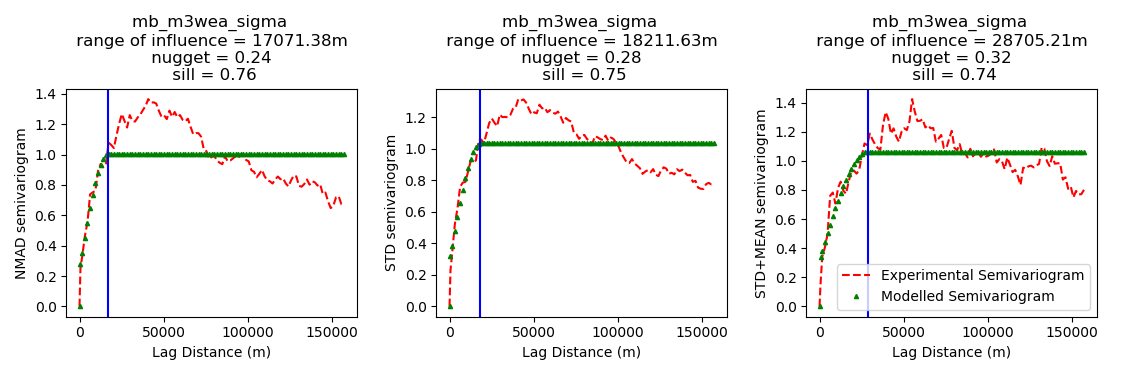

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [92]:
fig,axa = plt.subplots(1,3,figsize=(11.25,3.75))
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
#lag_dist = median_near_neig
lag_dist = 786.4773252363802*2
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[0],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
    simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[1],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
    simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[2])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[2],sill=sill)
axa[0].set_ylabel('NMAD semivariogram')
axa[1].set_ylabel('STD semivariogram')
axa[2].set_ylabel('STD+MEAN semivariogram')
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Spherical_Variogram_paradigm.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')

## Gaussian Variogram

<IPython.core.display.Javascript object>


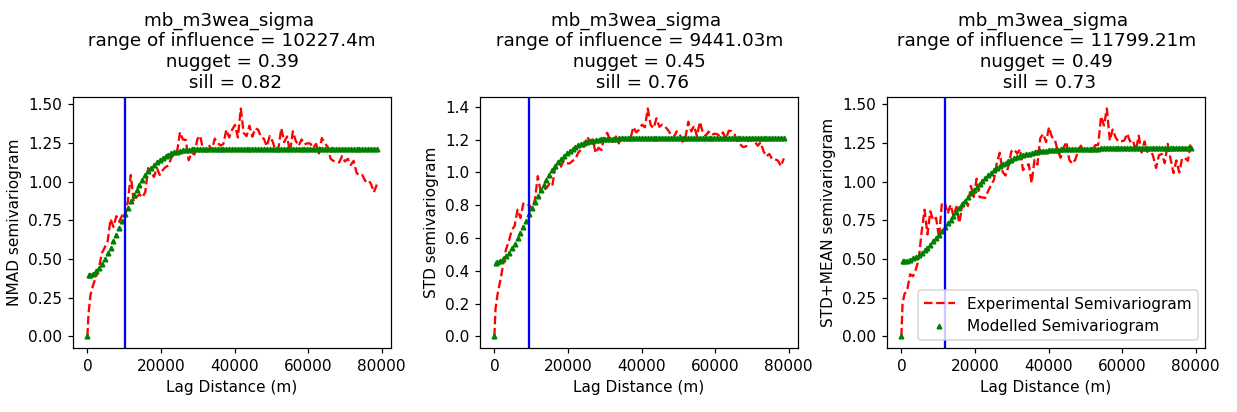

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [21]:
fig,axa = plt.subplots(1,3,figsize=(11.25,3.75))
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = gauss_variogram_wrapper(nmad_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[0],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = gauss_variogram_wrapper(std_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[1],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = gauss_variogram_wrapper(std_mean_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[2],sill=sill)
axa[0].set_ylabel('NMAD semivariogram')
axa[1].set_ylabel('STD semivariogram')
axa[2].set_ylabel('STD+MEAN semivariogram')
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Gaussian_Variogram_paradigm.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')

## Exponential Variogram

<IPython.core.display.Javascript object>


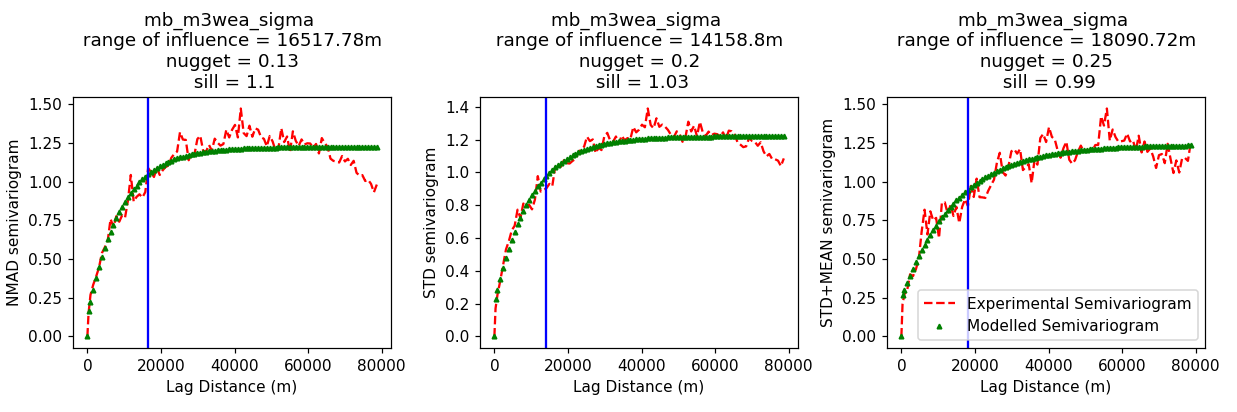

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [22]:
fig,axa = plt.subplots(1,3,figsize=(11.25,3.75))
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = exp_variogram_wrapper(nmad_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[0],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = exp_variogram_wrapper(std_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[1],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = exp_variogram_wrapper(std_mean_df,z,nlags,lag_dist)
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[2],sill=sill)
axa[0].set_ylabel('NMAD semivariogram')
axa[1].set_ylabel('STD semivariogram')
axa[2].set_ylabel('STD+MEAN semivariogram')
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Exponential_Variogram_paradigm.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')

#### Supplementary Figure


<IPython.core.display.Javascript object>


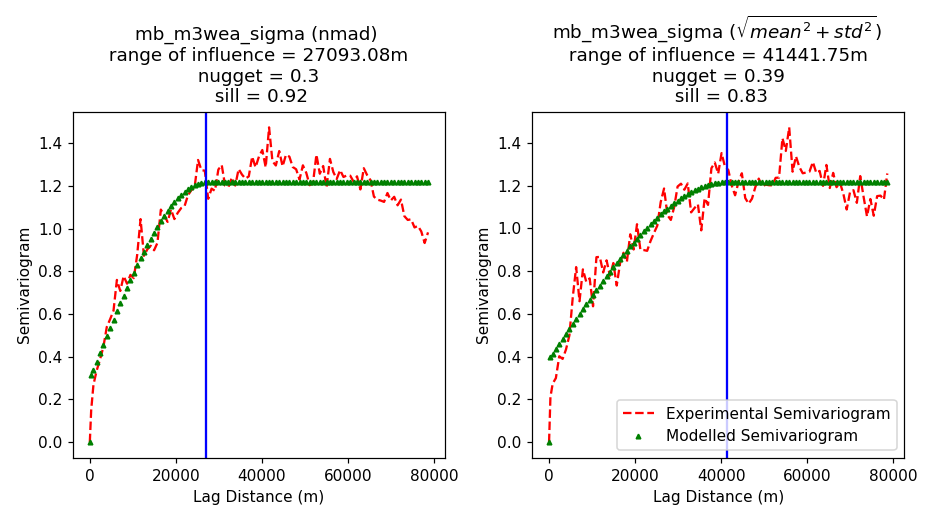

No handles with labels found to put in legend.


In [23]:
fig,axa = plt.subplots(1,2,figsize=(8.5,4.75))
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'mb_m3wea_sigma (nmad)',nugget,ax=axa[0],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
    simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'mb_m3wea_sigma ($\sqrt{mean^2+std^2}$)',nugget,ax=axa[1],sill=sill)
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Supplementary_Variogram.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')
fig.savefig(os.path.join(figdir,'Supplementary_Variogram.jpg'),dpi=300,pad_inches=0.01,bbox_inches='tight')

## Checking for sanity

- Modelling for a constant error value
- Modelling for random values distribution 
- Modelling for Constantly increasing value from West to East
- Modelling for constantly increasing value from South to North

<IPython.core.display.Javascript object>


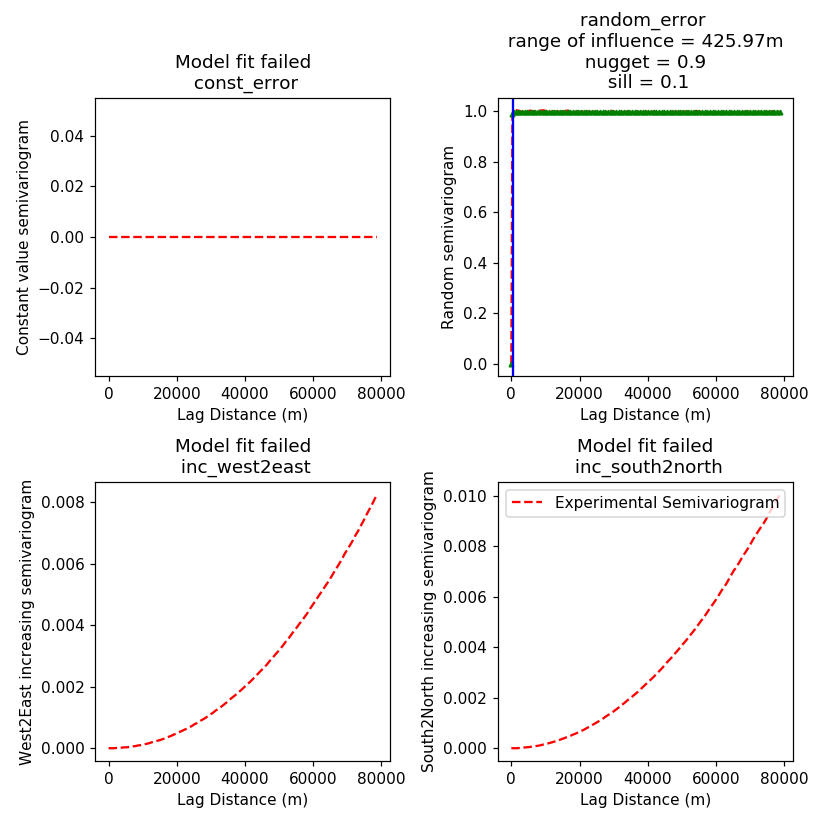

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [25]:
fig,axa = plt.subplots(2,2,figsize=(7.5,7.5))
z = 'const_error'
nmad_df[z] = [1]*len(nmad_df)
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0,0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[0,0],sill=sill)
#random error
z='random_error'
nmad_df[z] = np.random.rand(len(nmad_df))
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0,1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[0,1],sill=sill)
# systematic error (from west to east)
z = 'inc_west2east'
nmad_df.sort_values(by='x',inplace=True)
nmad_df[z] = np.arange(len(nmad_df))
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1,0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[1,0],sill=sill)
# systematic error (from south to north)
z = 'inc_south2north'
nmad_df.sort_values(by='y',inplace=True)
nmad_df[z] = np.arange(len(nmad_df))
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1,1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa[1,1],sill=sill)
axa[0,0].set_ylabel('Constant value semivariogram')
axa[0,1].set_ylabel('Random semivariogram')
axa[1,0].set_ylabel('West2East increasing semivariogram')
axa[1,1].set_ylabel('South2North increasing semivariogram')
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Variogram_paradigm_error_sanity_check.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')

### Sanity Check
- if all the values are constant, there is no variance in the data, the `experimental variogram` value is 0, `spherical variogram` fit fails
- if all the values are random, there is very `limited correaltion`, signified by `high nugget`, low `range of influence`
- on systematically increasing the values from West to East or North to South, the `experimental variogram` increases exponentially and does not level out at any distance, `spherical variogram` fit fails !

### Variogram anlysis for specific mass balance (mb_mwea), specific mass balance error (mb_mwea_sigma)

<IPython.core.display.Javascript object>


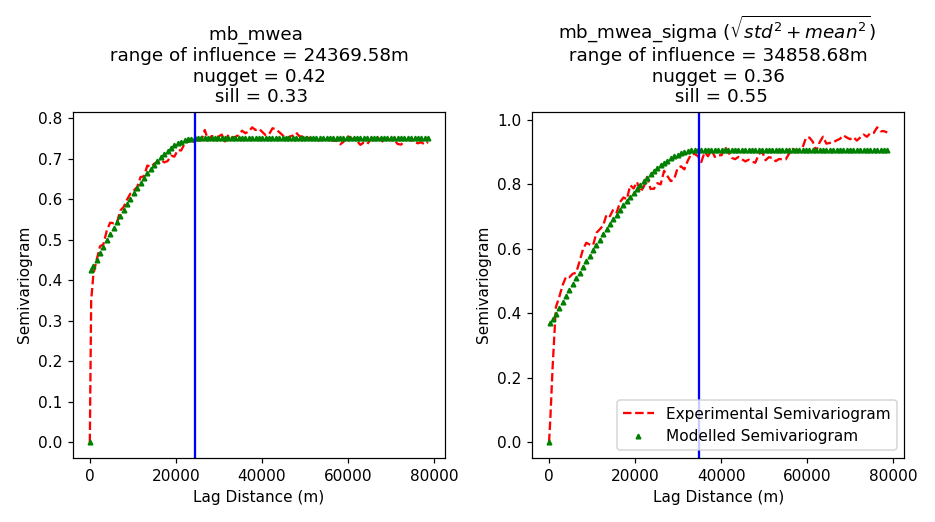

No handles with labels found to put in legend.


In [26]:
fig,axa = plt.subplots(1,2,figsize=(8.5,4.75))
z = 'mb_mwea'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'mb_mwea',nugget,ax=axa[0],sill=sill)
z = 'mb_mwea_sigma'
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist)
if len(gamma_mbm) <2:
    simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'mb_mwea_sigma ($\sqrt{std^2+mean^2}$)',nugget,ax=axa[1],sill=sill)
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Specific_Mass_balance_and_specific_mass_balance_error.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')

# Resource for interpretation:

- https://pdfs.semanticscholar.org/b14e/e3aee4eb1588b94ad1b84a588567d45f6976.pdf (In a more geological sense)

- Rolstad et al. 2009 https://www.cambridge.org/core/journals/journal-of-glaciology/article/spatially-integrated-geodetic-glacier-mass-balance-and-its-uncertainty-based-on-geostatistical-analysis-application-to-the-western-svartisen-ice-cap-norway/FDEA8679441059F0BA18E932F8710FBF

- Magnússon et al. 2016 https://www.the-cryosphere.net/10/159/2016/tc-10-159-2016.pdf
- Anderson, 2019 https://onlinelibrary.wiley.com/doi/full/10.1002/esp.4551

# Interpretation
- The high nugget effect we see here shows that there is small scale variability here
- Glaciers mass balance for glaciers located very close to each other vary very independtly and randomly
- like the classic Gold example, in smaller length scales, `glacier-wide` variations can be random and there may be many glaciers exhibiting unique responses.
- with increasing area, they tend to group up and show behaviour based on regions, region climate ?

- Glacier mass balance uncertainty (mb_m3wea_sigma) has range of influence around `27 km for NMAD error, 41-42 km for` \begin{equation*} \sqrt{mean^2+Std^2} \end{equation*} `error`
- Glacier mass balance uncertainty `mb_mwea_sigma` has a higher range of influence `36.7 km`

